Install Detectron2

Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [6]:
#---> pip install torch torchvision torchaudio
#---> python -m pip install pyyaml==5.1

import sys, os, distutils.core
print(sys.executable)
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
#---> python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

/home/pauloarbu/phpy/bin/python


In [9]:
import torch, detectron2

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Test CUDA device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")


#---> nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print(f"detectron2 version: {detectron2.__version__}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA GeForce RTX 4060
torch:  2.6 ; cuda:  cu124
detectron2 version: 0.6


Basic setup

In [12]:
# Setup detectron2 logger
import detectron2
import matplotlib.pyplot as plt
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


print(f"OpenCV version: {cv2.__version__}")


OpenCV version: 4.11.0


Train on a custom dataset

In this section, we train an existing detectron2 model on a custom dataset in a new format.

We use the blade defect segmentation dataset which only has one class: defect. We'll train a defect segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.


------- BEGINNING OF MODEL TRAINING: SEGMENT AND LOCATE BLADE DEFECTS ----------

1. Dataset Loading Function

In [ ]:
def get_blade_defect_dicts(directory, annotation_file):
    import json
    import os
    from detectron2.structures import BoxMode
    
    json_file = os.path.join(directory, annotation_file)
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    
    # Adjust this part based on your annotation format
    # For VIA format (similar to balloon dataset):
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        filename = os.path.join(directory, "images", v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            anno = anno["shape_attributes"]
            
            # For polygon annotations
            if "all_points_x" in anno:
                px = anno["all_points_x"]
                py = anno["all_points_y"]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]
                
                # Get the defect type from region_attributes
                # Adjust based on your annotation format
                defect_type = 0  # Default to first class
                if "region_attributes" in annos[_]:
                    region_attrs = annos[_]["region_attributes"]
                    if "defect_type" in region_attrs:
                        defect_type = DEFECT_CATEGORIES[region_attrs["defect_type"]]
                
                obj = {
                    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": defect_type,
                }
                objs.append(obj)
                
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

2. Define Defect Categories

In [ ]:
# Define your defect categories
DEFECT_TYPES = ["erosion", "crack", "delamination", "lightning_strike"]  # Replace with your actual defect types
DEFECT_CATEGORIES = {defect: i for i, defect in enumerate(DEFECT_TYPES)}

3. Register Dataset

In [ ]:
# Clear any existing registrations
for d in ["train", "val"]:
    dataset_name = f"blade_defect_{d}"
    if dataset_name in DatasetCatalog:
        DatasetCatalog.remove(dataset_name)

# Paths to your dataset
blade_defect_train_dir = "./datasets/blade_defects/train"
blade_defect_train_json = "annotations.json"  # Update with your actual filename
blade_defect_val_dir = "./datasets/blade_defects/val"
blade_defect_val_json = "annotations.json"  # Update with your actual filename

# Register with proper function references
def get_blade_defect_train():
    return get_blade_defect_dicts(blade_defect_train_dir, blade_defect_train_json)

def get_blade_defect_val():
    return get_blade_defect_dicts(blade_defect_val_dir, blade_defect_val_json)

DatasetCatalog.register("blade_defect_train", get_blade_defect_train)
DatasetCatalog.register("blade_defect_val", get_blade_defect_val)
MetadataCatalog.get("blade_defect_train").set(thing_classes=DEFECT_TYPES)
MetadataCatalog.get("blade_defect_val").set(thing_classes=DEFECT_TYPES)

4. Visualize Dataset (Optional)

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

# Visualize training data
blade_metadata = MetadataCatalog.get("blade_defect_train")
dataset_dicts = get_blade_defect_train()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=blade_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(12, 12))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

5. Configure and Train Model

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("blade_defect_train",)
cfg.DATASETS.TEST = ("blade_defect_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000  # Adjust based on dataset size
cfg.SOLVER.STEPS = []  # Learning rate decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(DEFECT_TYPES)
cfg.OUTPUT_DIR = "./output/blade_defect_model"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

------- END OF MODEL TRAINING: SEGMENT AND LOCATE BLADE DEFECTS ----------

Download and Register Ballon dataset (new)

In [25]:
# Download the balloon dataset if you haven't already
import os
import urllib.request
import zipfile

# Check if the dataset directory exists
if not os.path.exists("./datasets/balloon"):
    # Download the dataset
    os.makedirs("./datasets", exist_ok=True)
    balloon_dataset_url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
    urllib.request.urlretrieve(balloon_dataset_url, "./datasets/balloon_dataset.zip")

    # Extract the dataset
    with zipfile.ZipFile("./datasets/balloon_dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("./datasets")

# Register the dataset with a proper dataset mapper for VIA format
# REMOVE THIS LINE: from detectron2.data.datasets.balloon import register_balloon_instances

# Define the data paths
balloon_train_dir = "./datasets/balloon/train"
balloon_train_json = "./datasets/balloon/train/via_region_data.json"
balloon_val_dir = "./datasets/balloon/val"
balloon_val_json = "./datasets/balloon/val/via_region_data.json"

# Define a get_balloon_dicts function with a fixed directory parameter
def get_balloon_dicts(directory):
    import json
    import os
    from detectron2.structures import BoxMode
    
    json_file = os.path.join(directory, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        filename = os.path.join(directory, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Clear any existing registrations
for d in ["train", "val"]:
    dataset_name = f"balloon_{d}"
    if dataset_name in DatasetCatalog:
        DatasetCatalog.remove(dataset_name)

# Register with proper function references - no lambda expressions
def get_balloon_train():
    return get_balloon_dicts("./datasets/balloon/train")

def get_balloon_val():
    return get_balloon_dicts("./datasets/balloon/val")

DatasetCatalog.register("balloon_train", get_balloon_train)
DatasetCatalog.register("balloon_val", get_balloon_val)
MetadataCatalog.get("balloon_train").set(thing_classes=["balloon"])
MetadataCatalog.get("balloon_val").set(thing_classes=["balloon"])

namespace(name='balloon_val',
          json_file='./datasets/balloon/val/via_region_data.json',
          image_root='./datasets/balloon/val',
          evaluator_type='coco',
          thing_classes=['balloon'])

In [26]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/30 21:51:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/30 21:51:05 d2.engine.train_loop]: Starting training from iteration 0
[03/30 21:51:23 d2.utils.events]:  eta: 0:03:45  iter: 19  total_loss: 2.066  loss_cls: 0.609  loss_box_reg: 0.7057  loss_mask: 0.6825  loss_rpn_cls: 0.04548  loss_rpn_loc: 0.00888    time: 0.9426  last_time: 0.7803  data_time: 0.0120  last_data_time: 0.0097   lr: 1.6068e-05  max_mem: 3317M
[03/30 21:51:41 d2.utils.events]:  eta: 0:03:22  iter: 39  total_loss: 1.814  loss_cls: 0.545  loss_box_reg: 0.6016  loss_mask: 0.5884  loss_rpn_cls: 0.05186  loss_rpn_loc: 0.006793    time: 0.9286  last_time: 0.6333  data_time: 0.0061  last_data_time: 0.0064   lr: 3.2718e-05  max_mem: 3317M
[03/30 21:51:59 d2.utils.events]:  eta: 0:03:09  iter: 59  total_loss: 1.629  loss_cls: 0.448  loss_box_reg: 0.6563  loss_mask: 0.4877  loss_rpn_cls: 0.02797  loss_rpn_loc: 0.008268    time: 0.9580  last_time: 1.2515  data_time: 0.0075  last_data_time: 0.0237   lr: 4.9367e-05  max_mem: 3437M
[03/30 21:52:17 d2.utils.events]:  eta: 0:02:54 

In [28]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20140), started 0:01:13 ago. (Use '!kill 20140' to kill it.)

Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

Other types of builtin models
We showcase simple demos of other types of models below:

Run panoptic segmentation on a video

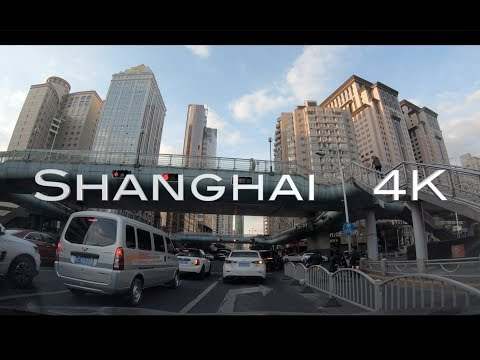

In [29]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [32]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

[youtube] ll8TgCZ0plk: Downloading webpage
ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.
/bin/bash: line 1: ffmpeg: command not found


Alternativa, dada pelo claude

In [37]:
# Install yt-dlp (more modern alternative to youtube-dl) and ffmpeg
!pip install yt-dlp
#--> sudo apt-get update && sudo apt-get install -y ffmpeg

# Download the video using yt-dlp
!yt-dlp https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4

# Crop 6 seconds from the video
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

[youtube] Extracting URL: https://www.youtube.com/watch?v=ll8TgCZ0plk
[youtube] ll8TgCZ0plk: Downloading webpage
[youtube] ll8TgCZ0plk: Downloading tv client config
[youtube] ll8TgCZ0plk: Downloading player 20830619
[youtube] ll8TgCZ0plk: Downloading tv player API JSON
[youtube] ll8TgCZ0plk: Downloading ios player API JSON
[youtube] ll8TgCZ0plk: Downloading m3u8 information
ERROR: [youtube] ll8TgCZ0plk: Requested format is not available. Use --list-formats for a list of available formats
ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconf

In [34]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15771 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 751.00 KiB/s, done.
Resolving deltas: 100% (11532/11532), done.


ModuleNotFoundError: No module named 'vision'

In [ ]:
# Download the results
#from google.colab import files
#files.download('video-output.mkv')

ModuleNotFoundError: No module named 'google.colab'

In [36]:
# Option 1: Display video file path
import os
output_file = 'video-output.mkv'
print(f"Video saved to: {os.path.abspath(output_file)}")

# Option 2: Display a video frame from the output to verify it worked
import cv2
import matplotlib.pyplot as plt

def display_video_frame(video_path, frame_number=0):
    """Display a specific frame from a video file"""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Frame {frame_number} from {video_path}")
        plt.show()
    else:
        print(f"Could not read frame {frame_number} from {video_path}")

# Display the first frame of the output video
display_video_frame('video-output.mkv')

Video saved to: /home/pauloarb/video-output.mkv
Could not read frame 0 from video-output.mkv
